In [11]:
from transpile_benchy.interface import QASMBench, RedQueen

qasm_bench_s = QASMBench(size="small")
qasm_bench_m = QASMBench(size="medium")
# redqueen = RedQueen()

from transpile_benchy.metrics import DepthMetric

depth_metric = DepthMetric()

from qiskit.transpiler import CouplingMap

coupling_map = CouplingMap.from_grid(6, 6)
# coupling_map = CouplingMap.from_grid(2,2)
coupling_map = CouplingMap.from_heavy_hex(5)

from virtual_swap.pass_managers import SabreVS, SabreQiskit  # , QiskitLevel3

In [12]:
# # 5Q backend = provider.backend.ibmq_quito
# from qiskit.providers.fake_provider import FakeQuitoV2
# coupling_map = FakeQuitoV2().target.build_coupling_map()
# # # GHZ/BV, QV, EfficientSU2-linear, EfficientSU2-full, Two-local linear, QFT,
# # from qiskit import QuantumCircuit
# # def ghz():
# #     num_qubits = 5
# #     qc = QuantumCircuit(num_qubits, num_qubits, name="ghz")

# #     # Create a GHZ state
# #     qc.h(0)
# #     for i in range(num_qubits - 1):
# #         qc.cx(i, i + 1)
# #     # Insert a barrier before measurement
# #     qc.barrier()
# #     # Measure all of the qubits in the standard basis
# #     for i in range(num_qubits):
# #         qc.measure(i, i)
# #     return qc

# # from qiskit.circuit.library import QuantumVolume
# # def qv():
# #     return QuantumVolume(5, seed=0)

In [13]:
# 5Q backend = provider.backend.ibmq_quito
# 20Q backend = provider.backend.ibmq_mumbai
from typing import Callable, List
from transpile_benchy.interface import QiskitInterface

from qiskit.circuit.library import QFT

qft_8 = QFT(8)
qft_8.name = "qft_8"
qft_12 = QFT(12)
qft_12.name = "qft_12"
qft_16 = QFT(16)
qft_16.name = "qft_16"
qft_20 = QFT(20)
qft_20.name = "qft_20"
qft_24 = QFT(24)
qft_24.name = "qft_24"
qft_28 = QFT(28)
qft_28.name = "qft_28"
qft_32 = QFT(32)
qft_32.name = "qft_32"
qft_36 = QFT(36)
qft_36.name = "qft_36"


# FIXME seems to be a bug , missing iteration over last element in the list
class QiskitFunctions(QiskitInterface):
    def _get_qiskit_functions(self) -> List[Callable]:
        return [qft_8, qft_12, qft_16, qft_20, qft_24, qft_28, qft_32, qft_36]


qiskit_functions = QiskitFunctions()

In [14]:
import logging
from transpile_benchy.benchmark import Benchmark

# Create a specific logger for transpile_benchy and set its level to DEBUG
transpile_benchy_logger = logging.getLogger("transpile_benchy")
# transpile_benchy_logger.setLevel(logging.DEBUG)
transpile_benchy_logger.setLevel(logging.INFO)

# Silence the qiskit logger by setting its level to WARNING or higher
qiskit_logger = logging.getLogger("qiskit")
qiskit_logger.setLevel(logging.WARNING)

benchmark = Benchmark(
    transpilers=[
        SabreQiskit(coupling_map),  # , cx_basis=True),
        SabreVS(coupling_map, logger=transpile_benchy_logger)  # , cx_basis=True),
        # QiskitLevel3(coupling_map),
    ],
    submodules=[qiskit_functions],
    metrics=[depth_metric],
    logger=transpile_benchy_logger,
    num_runs=5,
)
benchmark.run()

INFO:transpile_benchy:Running benchmarks for circuits...
Running circuits for QiskitFunctions:   0%|          | 0/8 [00:04<?, ?it/s]


KeyboardInterrupt: 

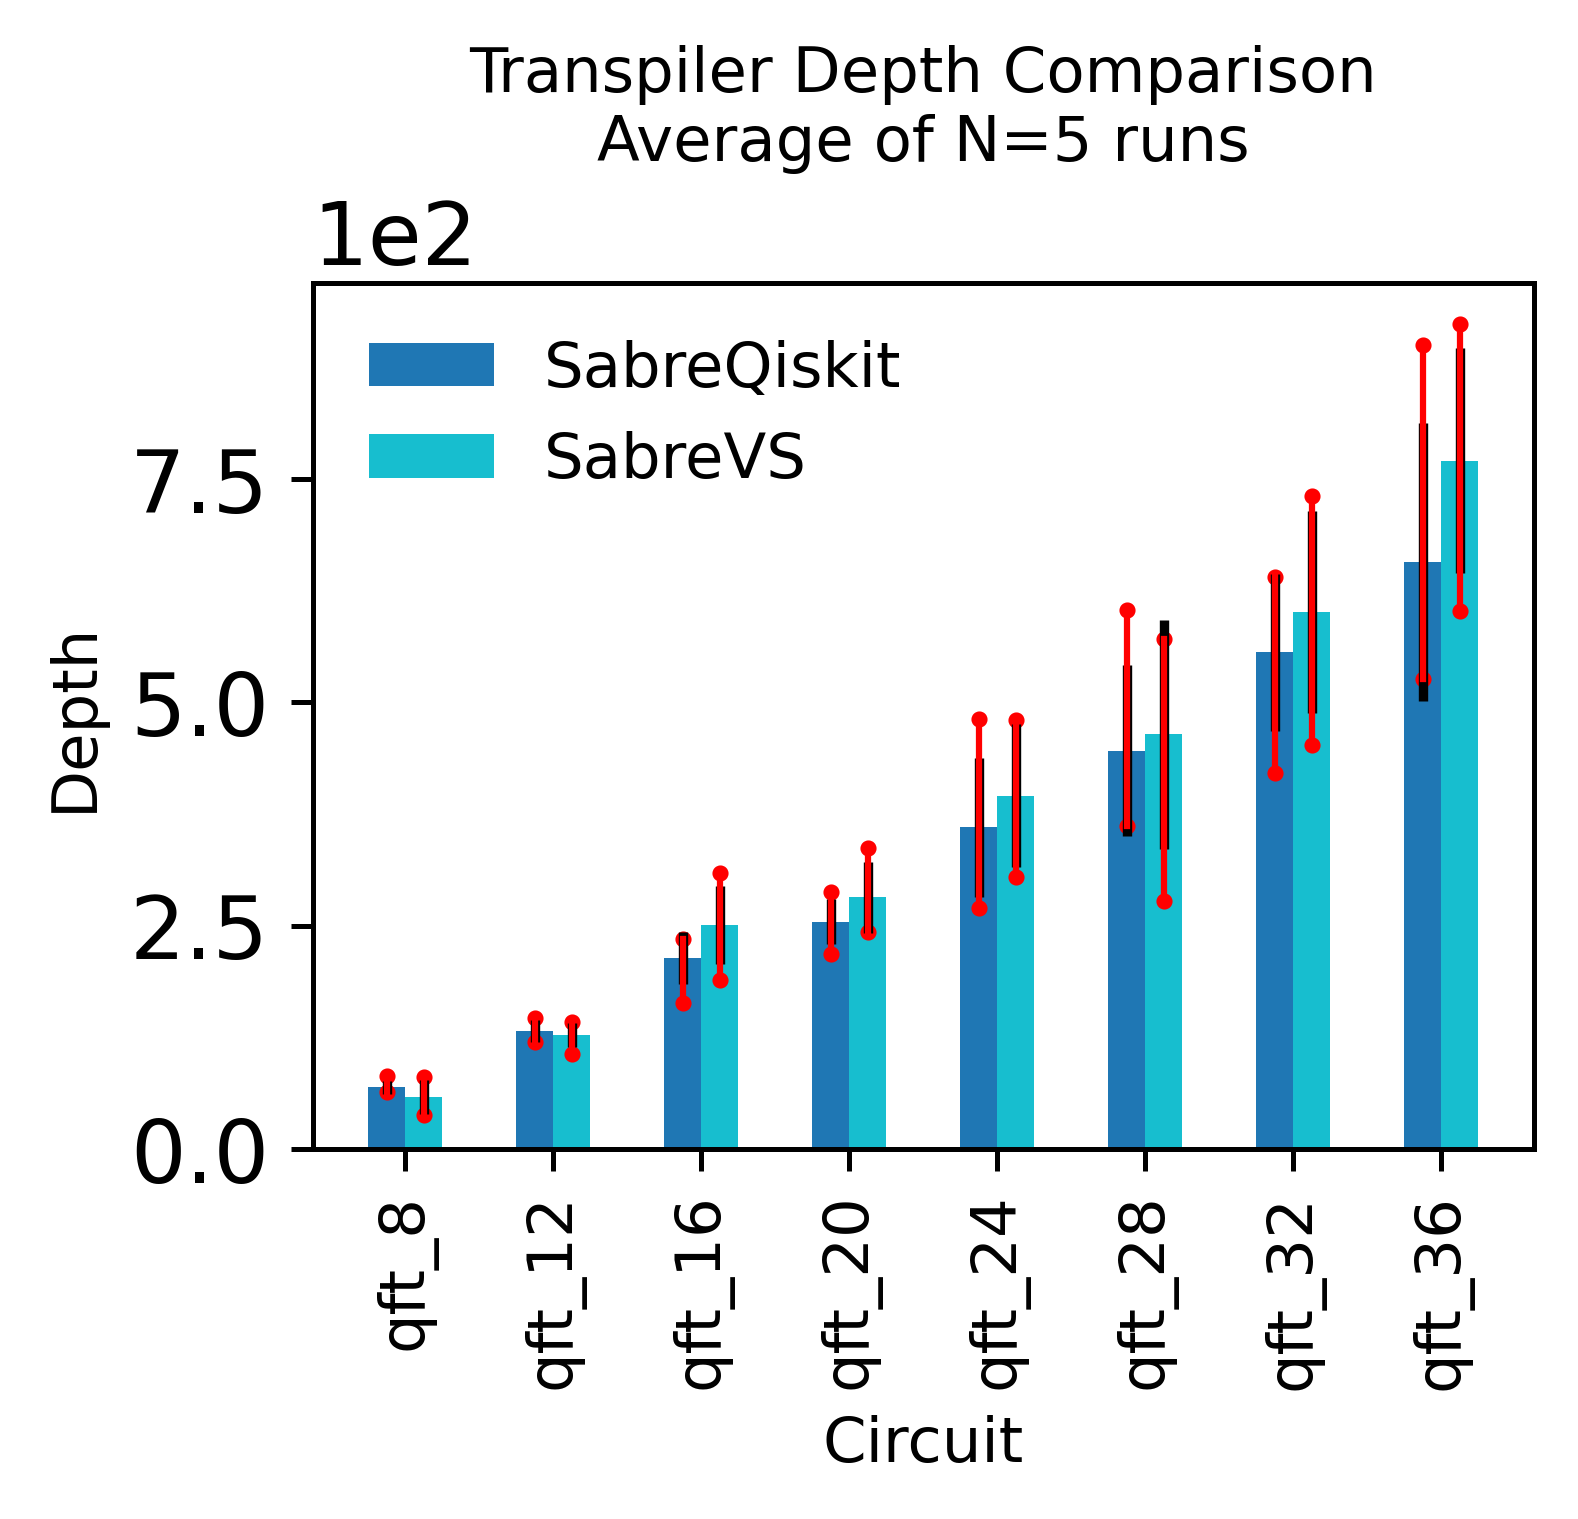

In [62]:
benchmark.plot()

### Below used for debugging indivudal circuit runs


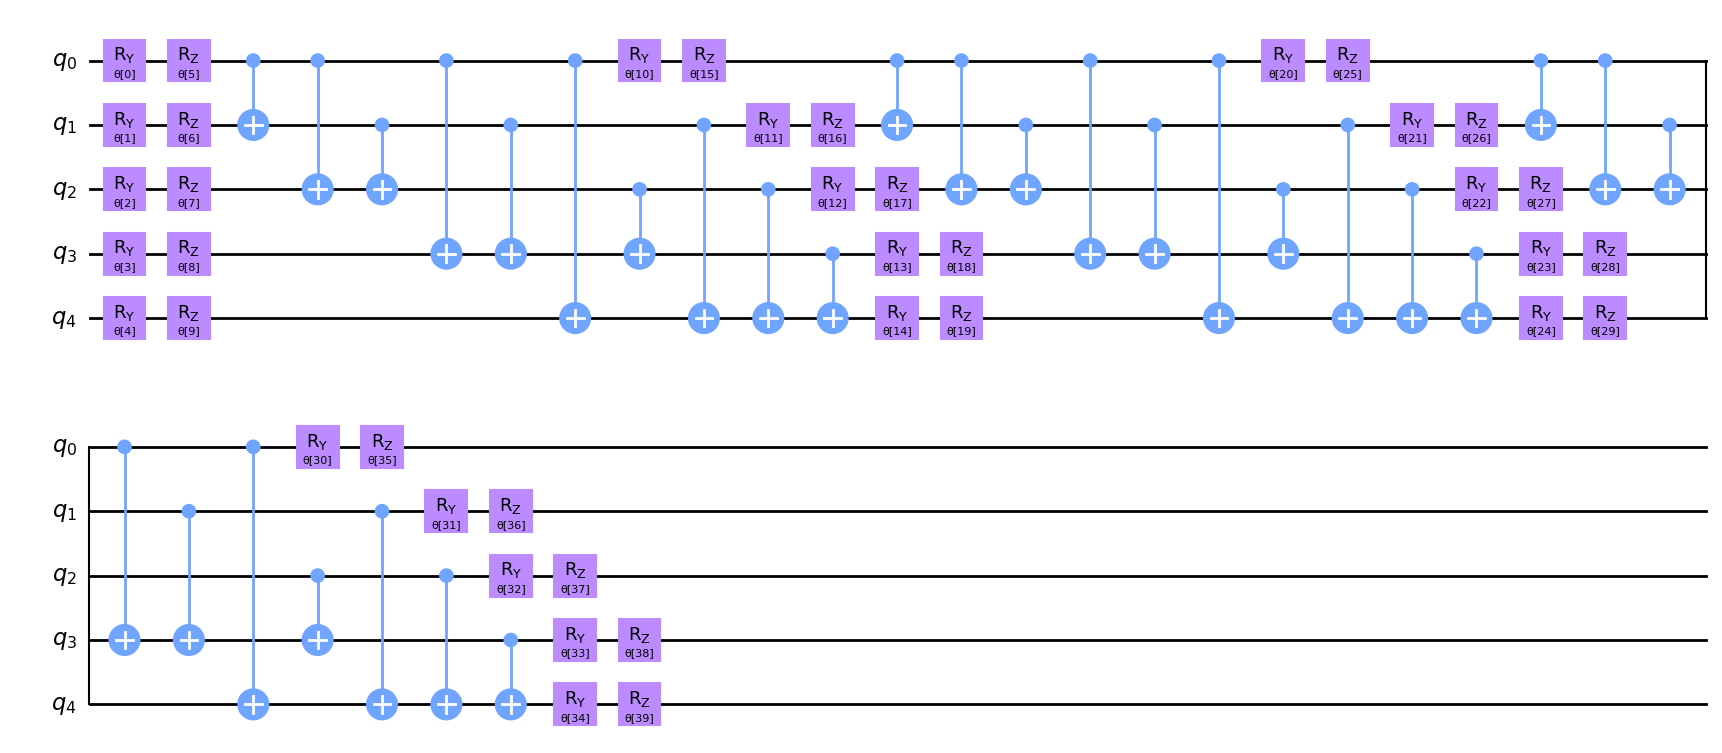

In [43]:
from qiskit.circuit.library import QuantumVolume, EfficientSU2, TwoLocal, QFT

qc = EfficientSU2(5, entanglement="full")
# from qiskit import QuantumCircuit
# qc = QuantumCircuit(3)
# qc.ccx(0,1,2)
qc.decompose().draw("mpl")

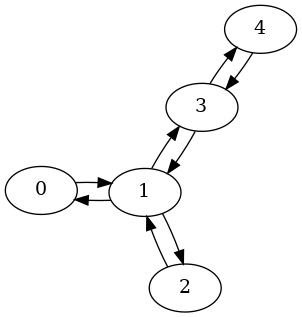

In [44]:
from qiskit.providers.fake_provider import FakeQuitoV2

coupling_map = FakeQuitoV2().target.build_coupling_map()
coupling_map.draw()

In [45]:
# from qiskit.circuit.library import QFT

# # coupling_map = CouplingMap.from_line(5)
# coupling_map = CouplingMap.from_grid(5, 6)
# # qc = QFT(8)
# # qc = QuantumCircuit(8)
# # qc.h(0)
# # qc.cx(0, 1)
# # qc.cx(1, 2)
# # qc.cx(2, 3)
# # # qc.cx(3, 4)
# # qc.cx(4, 5)
# # qc.cx(5, 6)
# # qc.cx(6, 7)
# qc.decompose().draw(output="mpl")

78


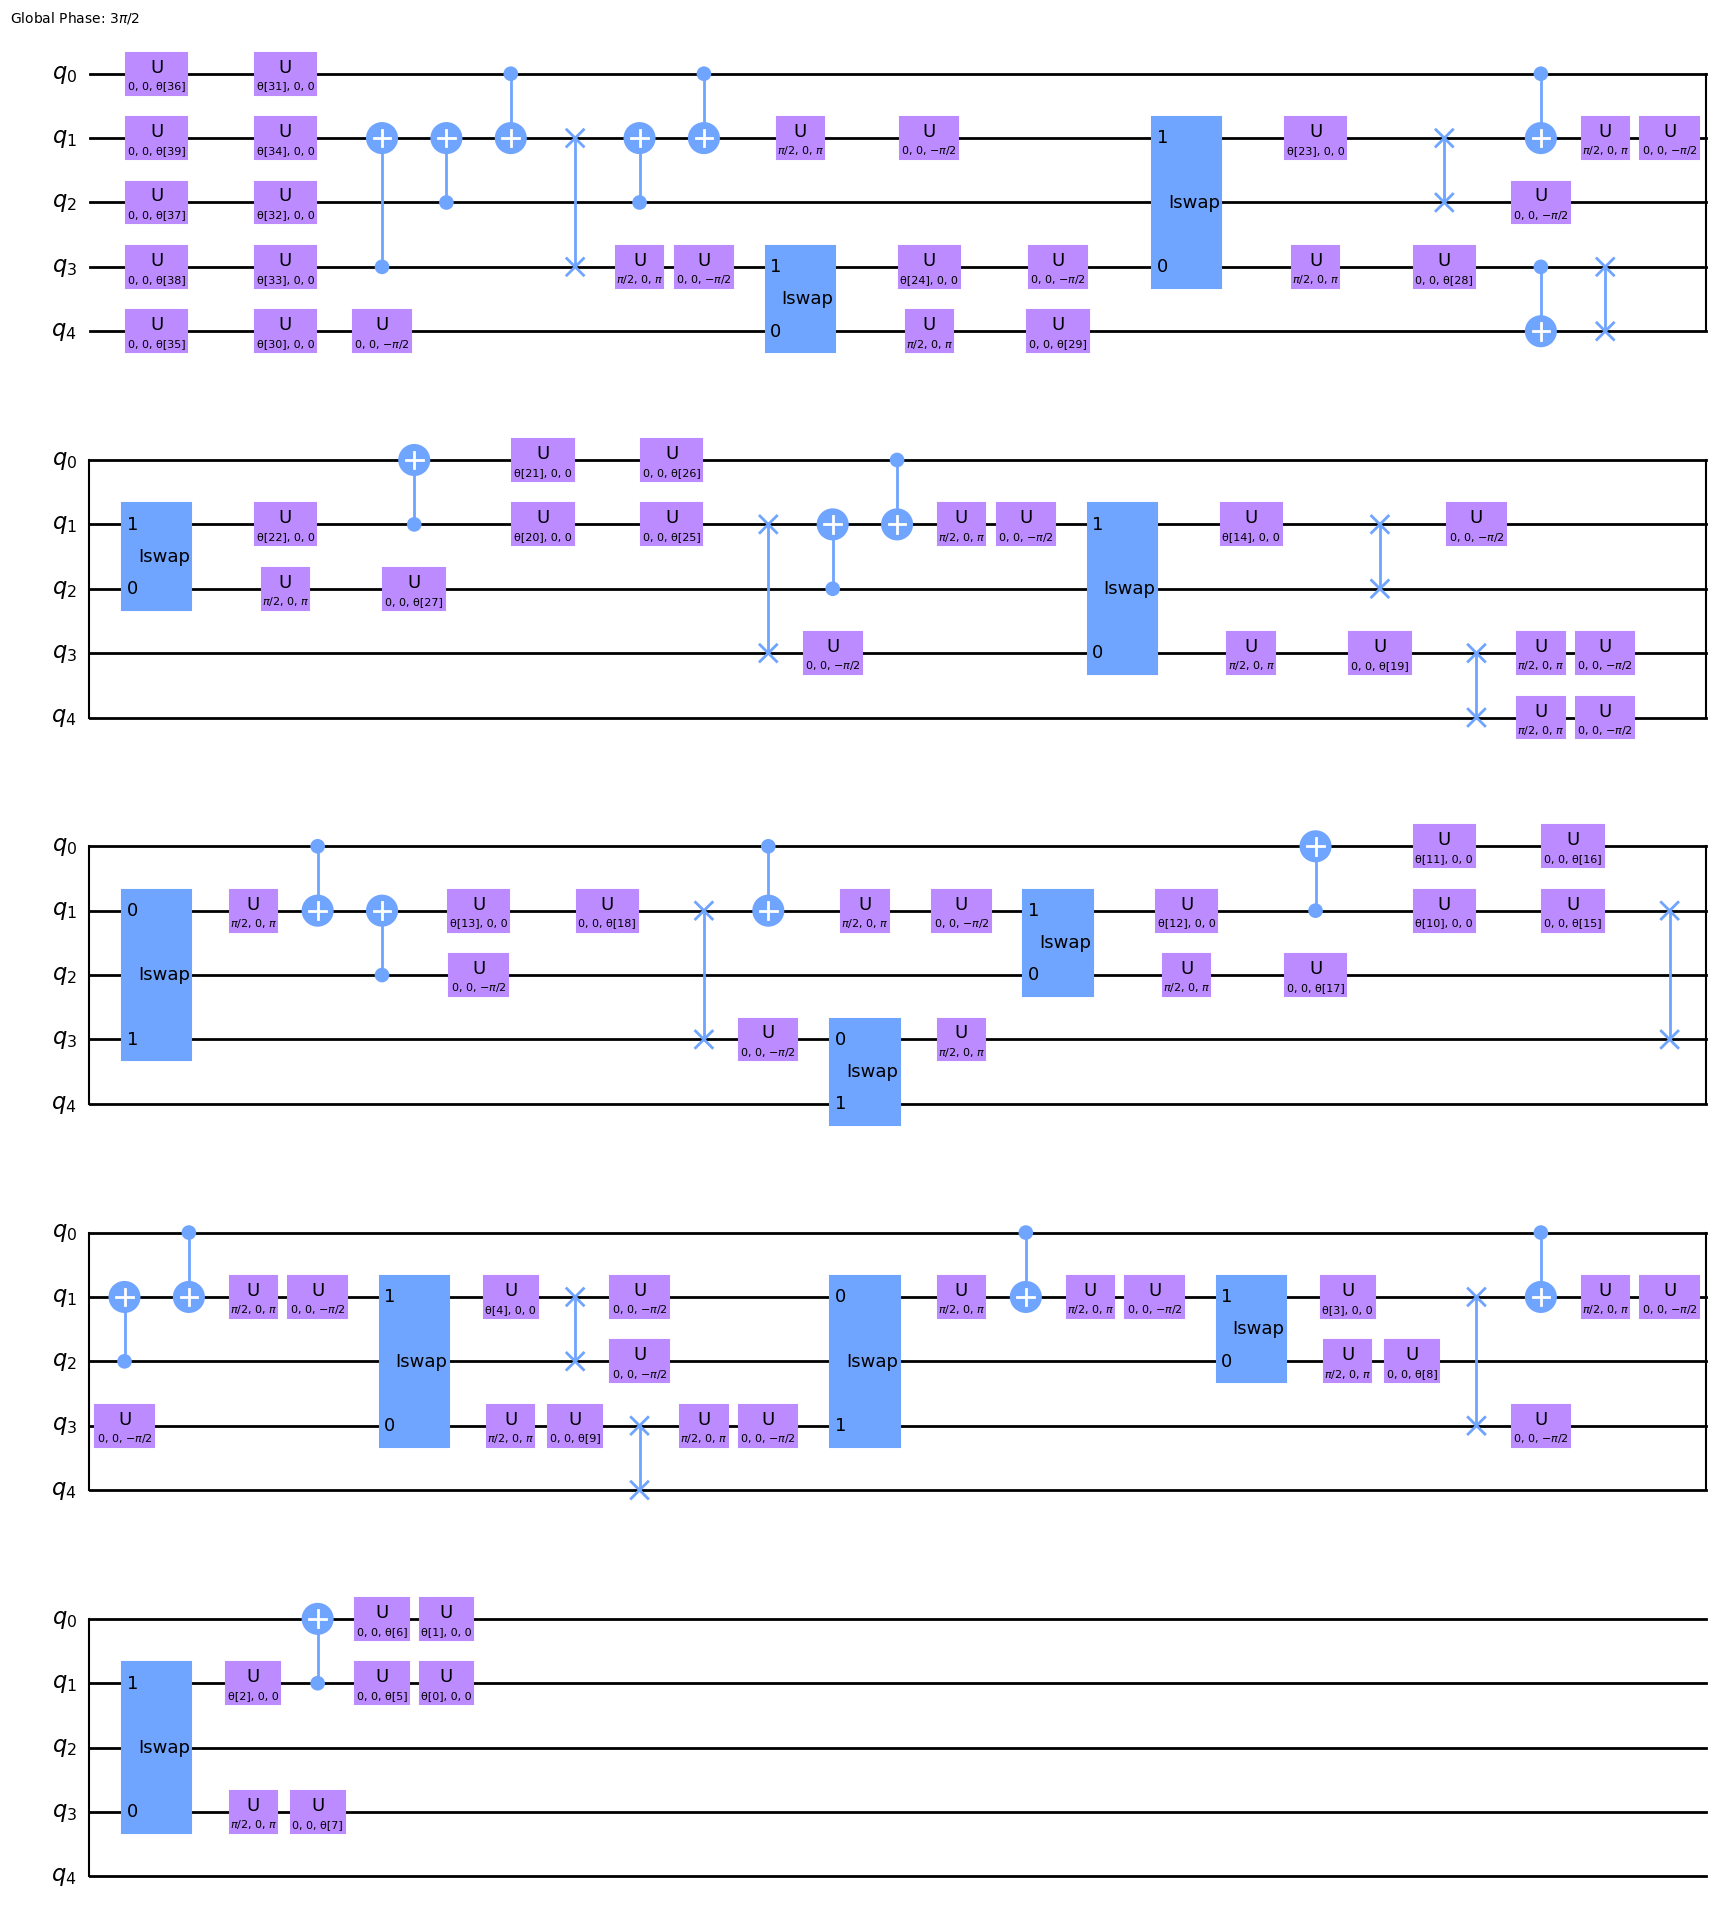

In [49]:
from virtual_swap.pass_managers import SabreVS

runner = SabreVS(coupling_map)  # , cx_basis=True)
transp = runner.run(qc)
mid = runner.pm.property_set["circuit_progress"]
print(DepthMetric.calculate(transp))
mid.draw(output="mpl")
# transp.draw(output="mpl")

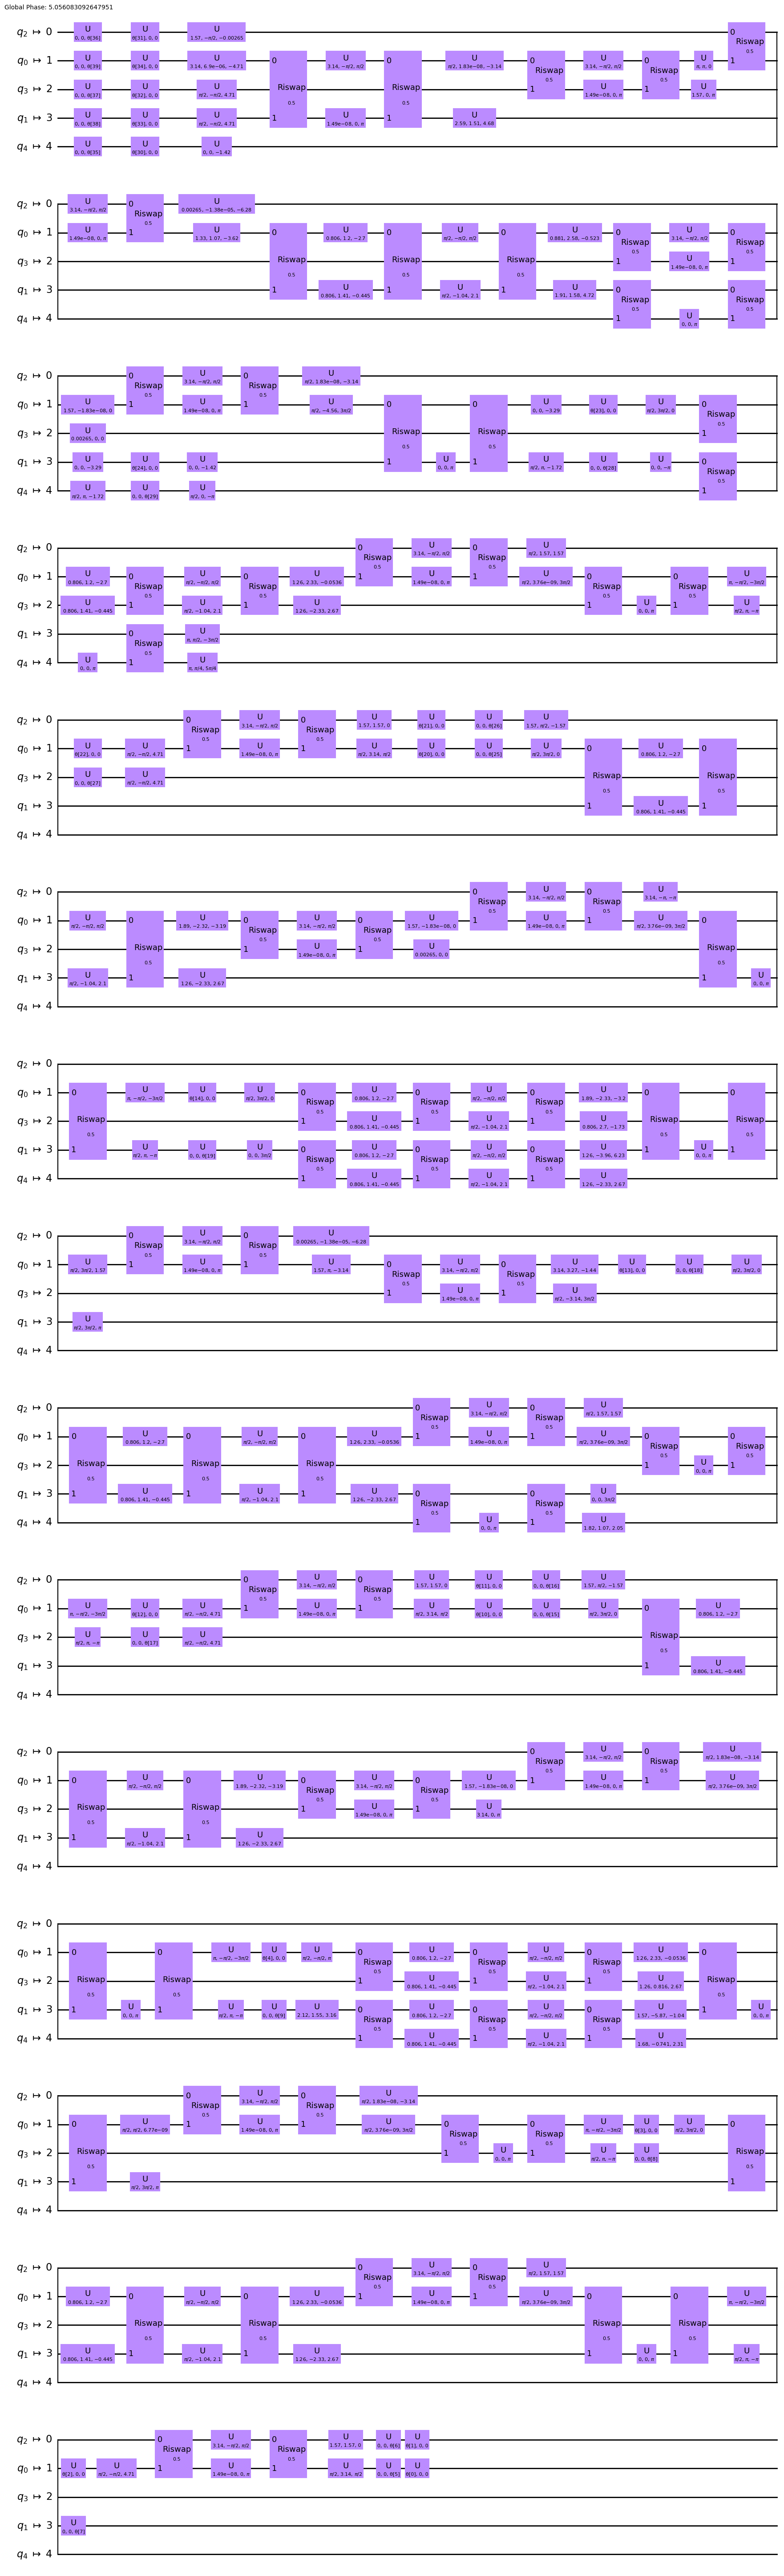

In [50]:
transp.draw(output="mpl")

In [28]:
# runner.pm.property_set["layout"]

96


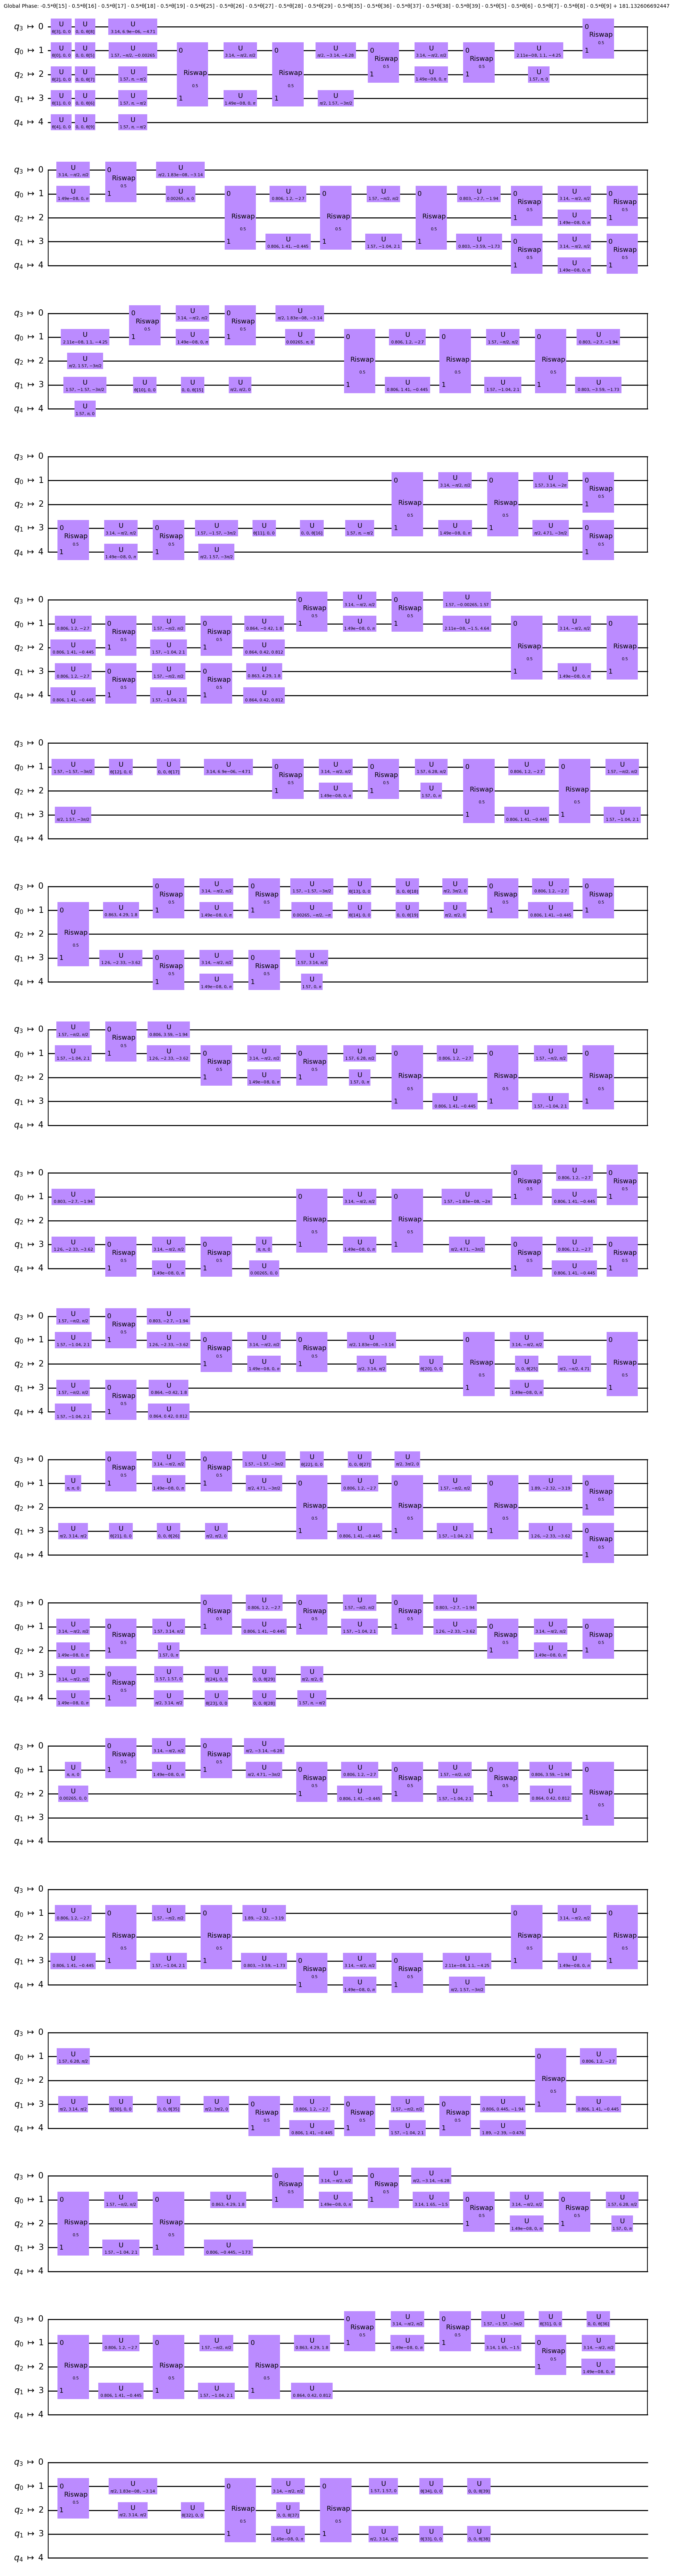

In [51]:
# set original qc to use
from qiskit import transpile

# qc2 = transpile(qc, initial_layout=runner.pm.property_set["layout"], coupling_map=coupling_map)
# qc2 = transpile(qc, coupling_map=coupling_map, optimization_level=3)
pm2 = SabreQiskit(coupling_map)  # , cx_basis=True)
qc2 = pm2.run(qc)
print(DepthMetric.calculate(qc2))
qc2.draw("mpl")

In [30]:
# from qiskit.quantum_info import Operator
# Operator(mid).equiv(qc2)